<a href="https://colab.research.google.com/github/1724prachiti/ousums/blob/main/JSK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun  8 16:48:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.9 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76


In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "/content/6_copy2.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

In [ ]:
#new
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

14


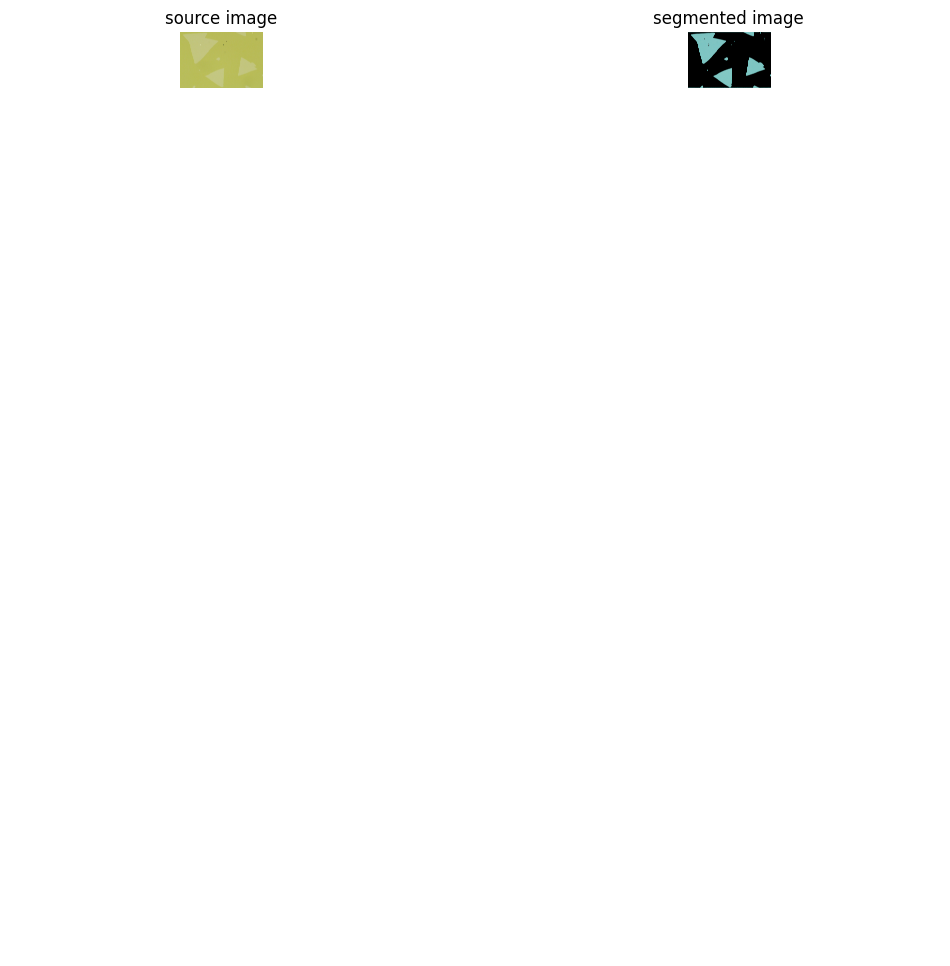

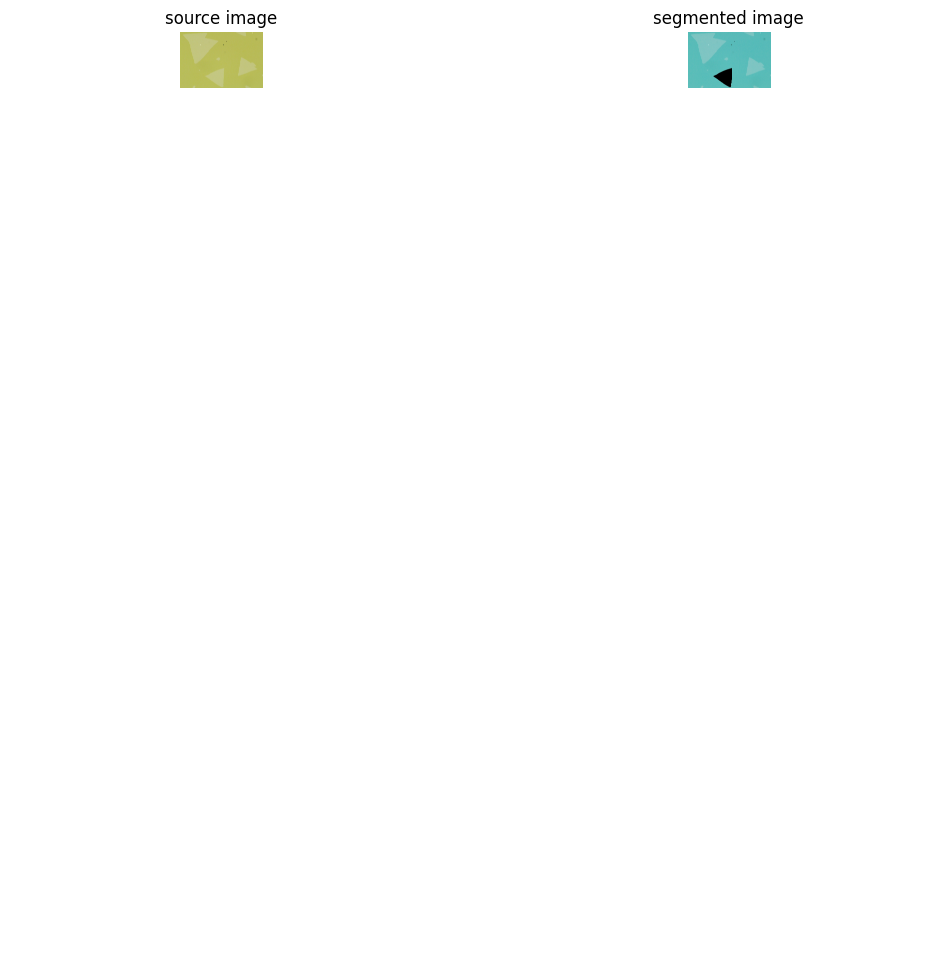

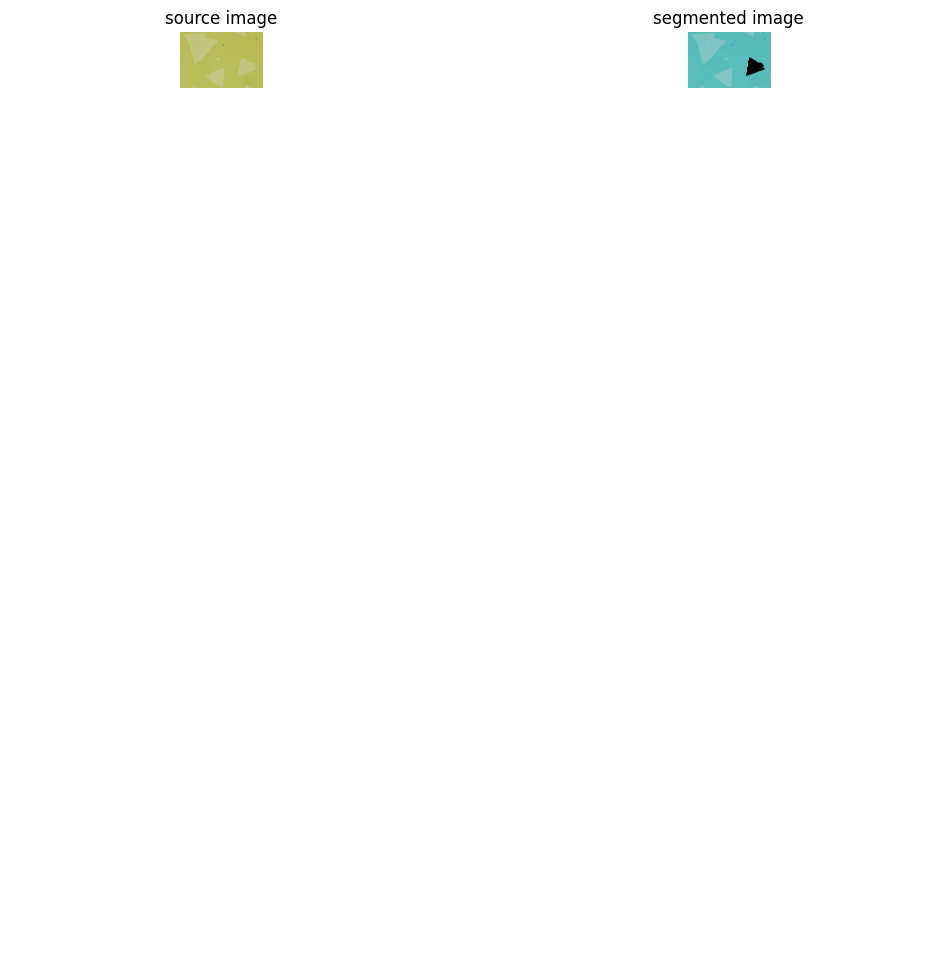

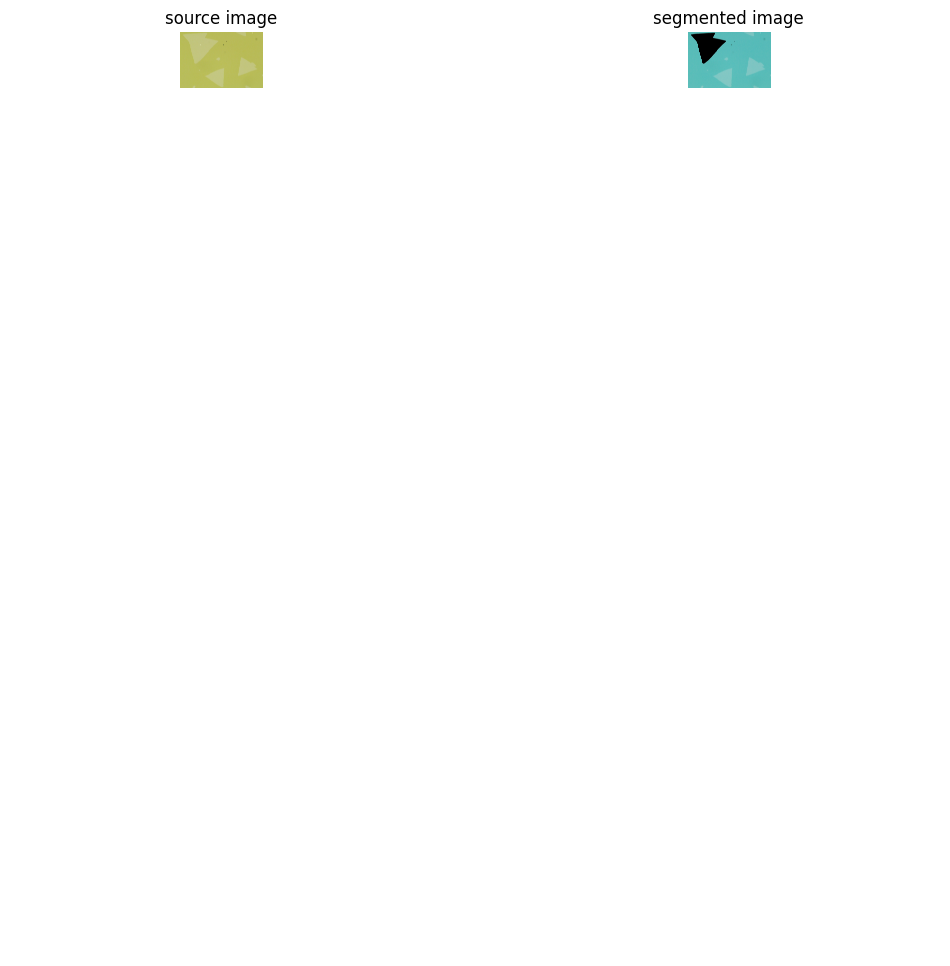

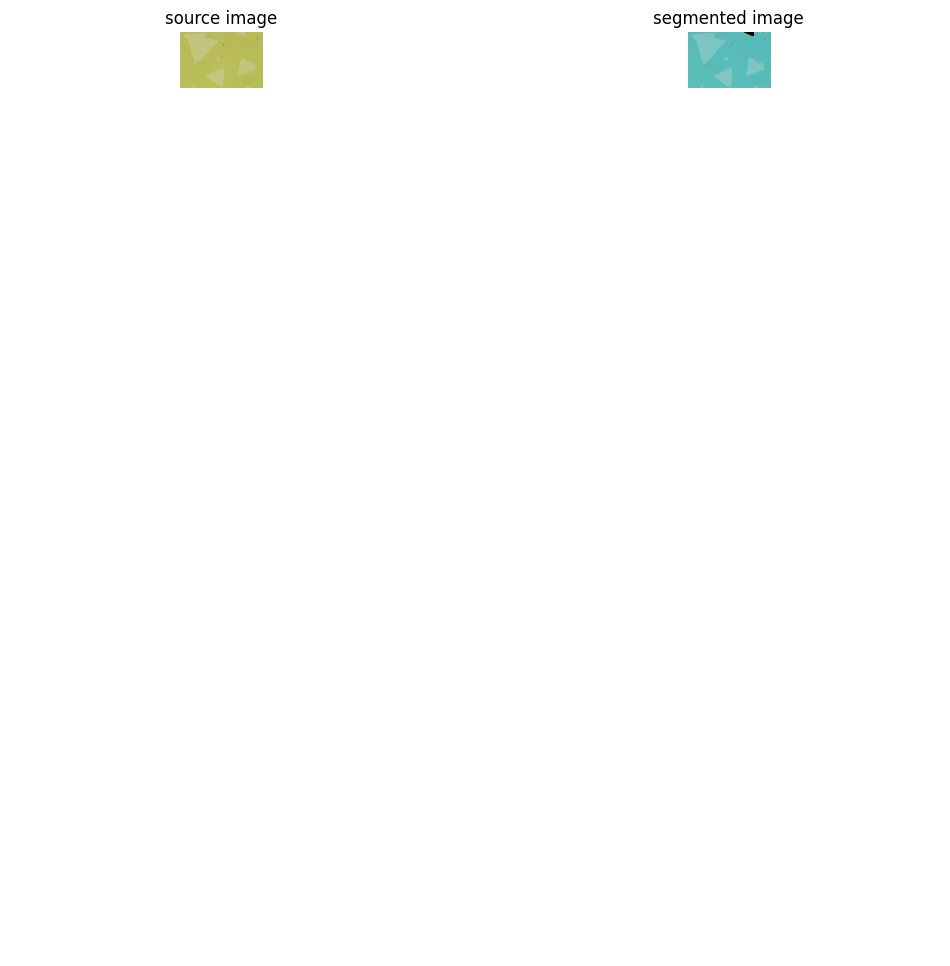

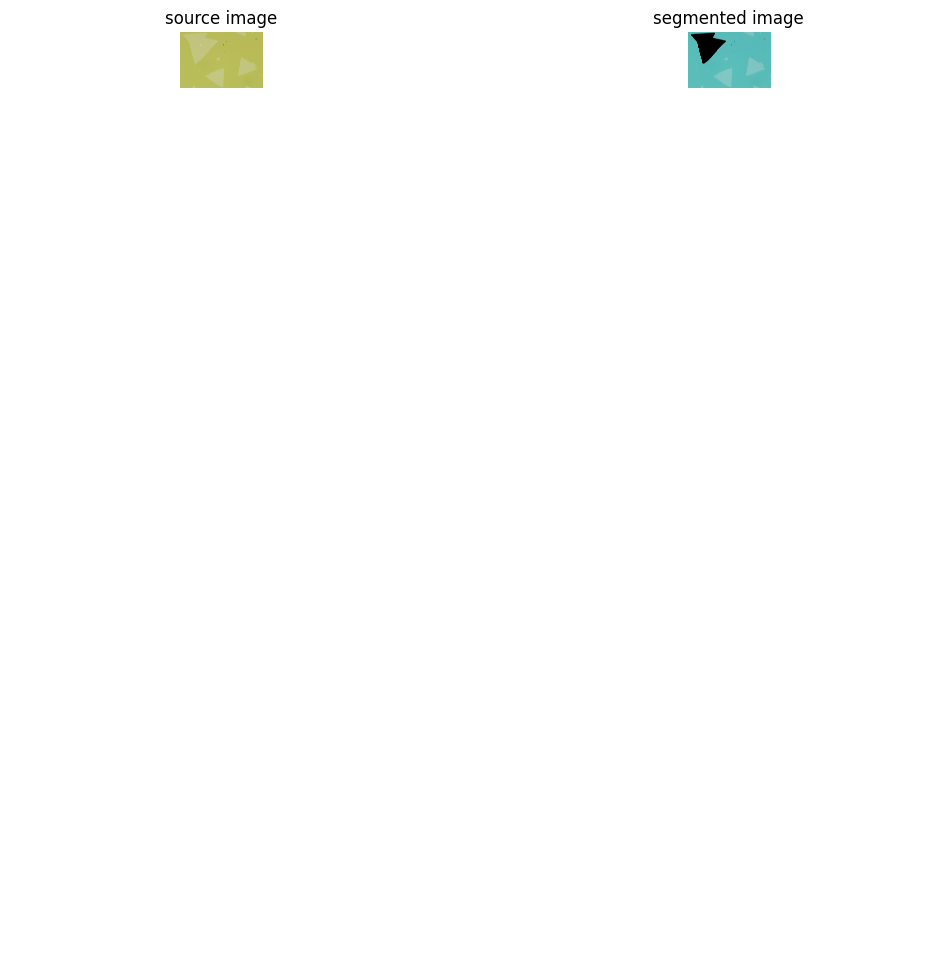

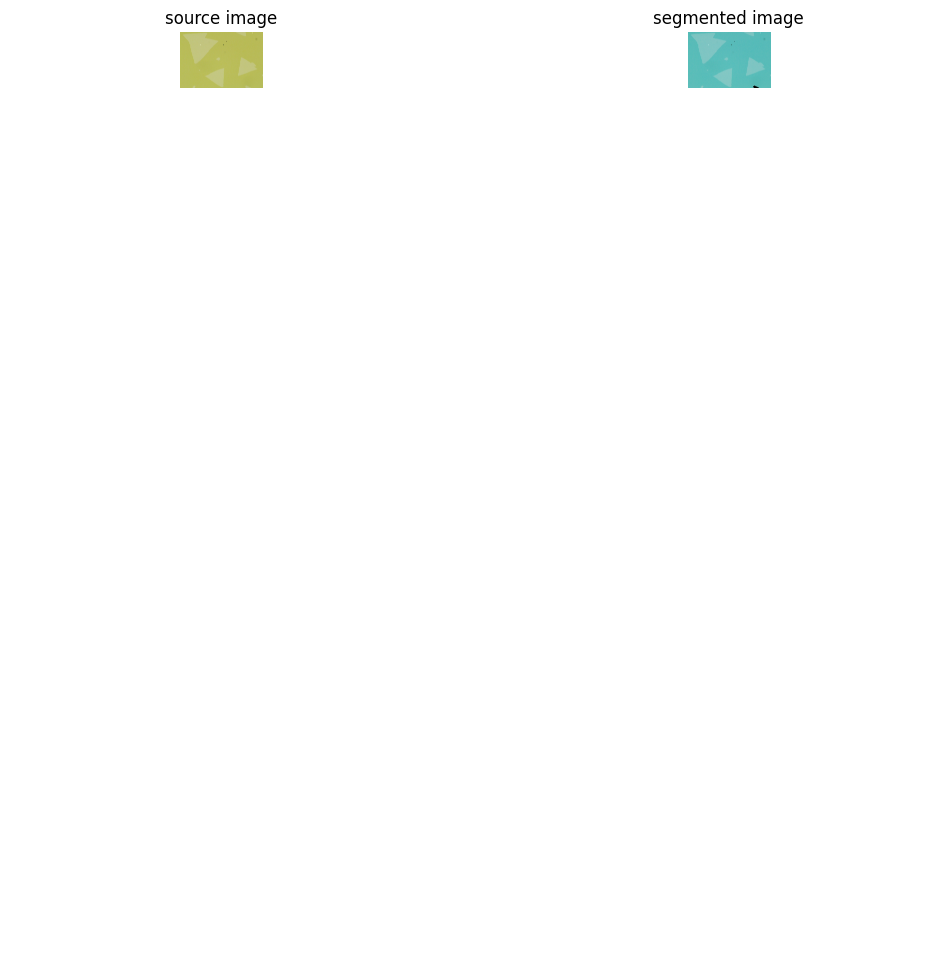

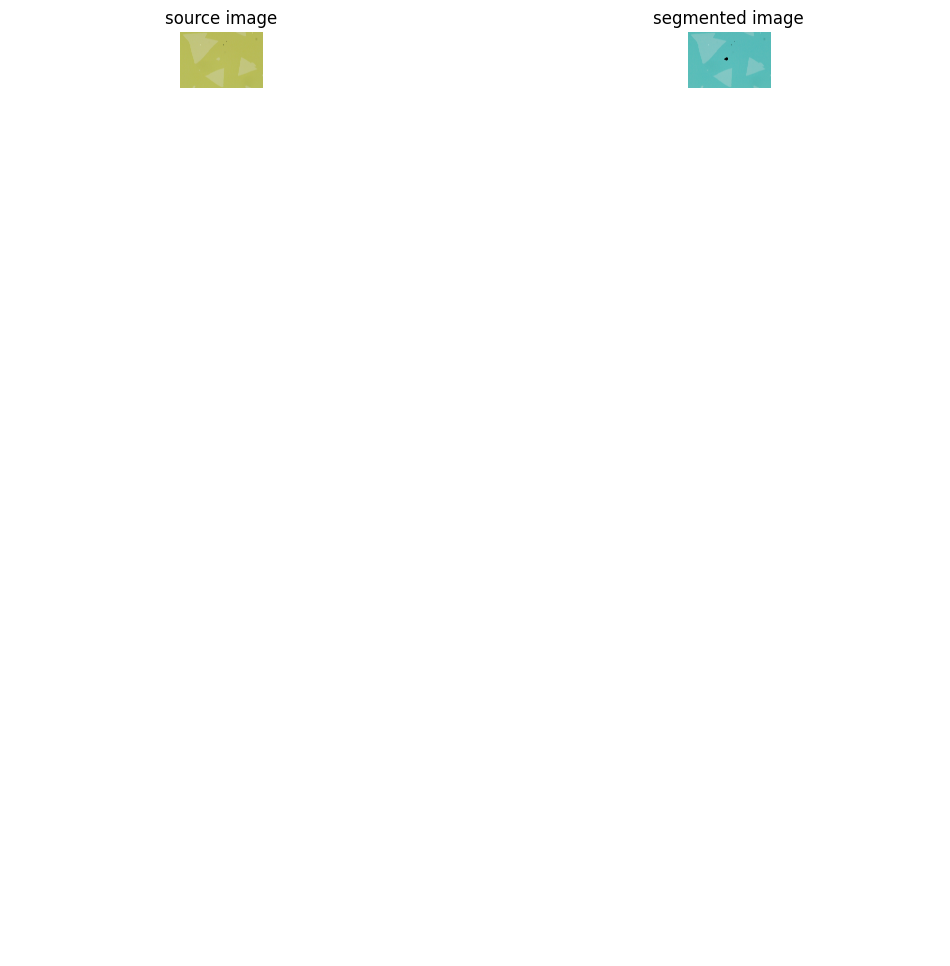

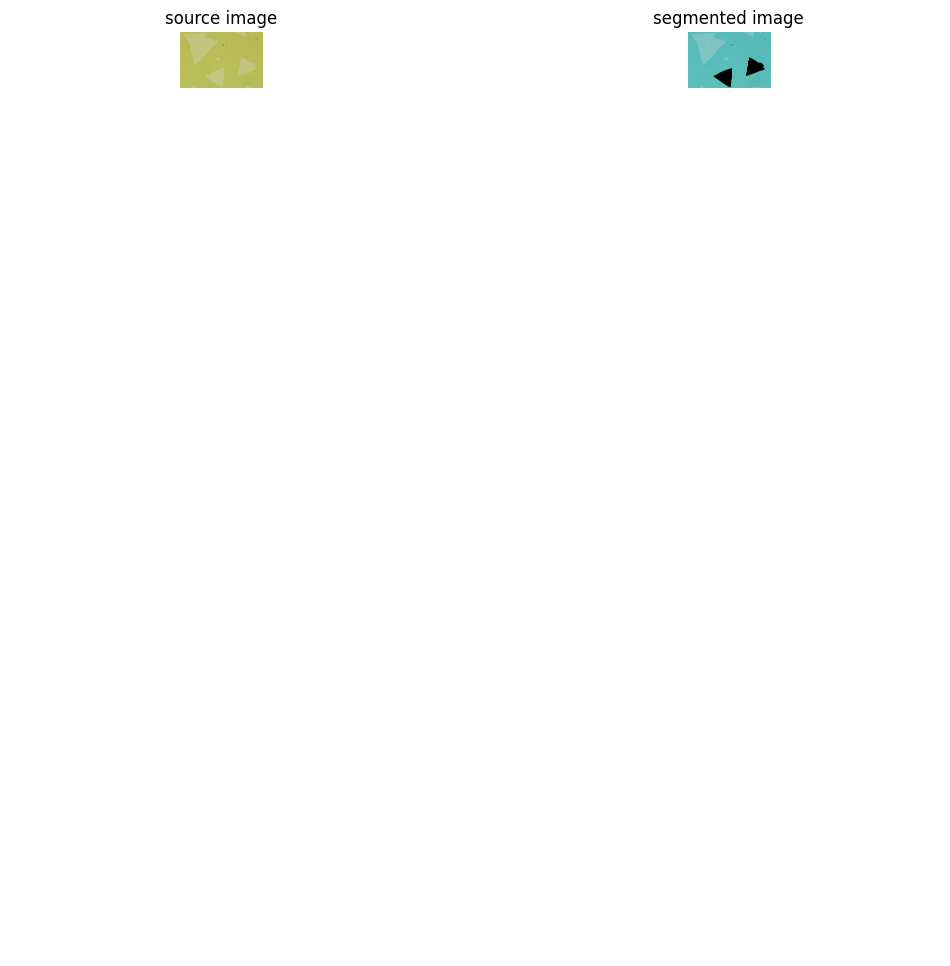

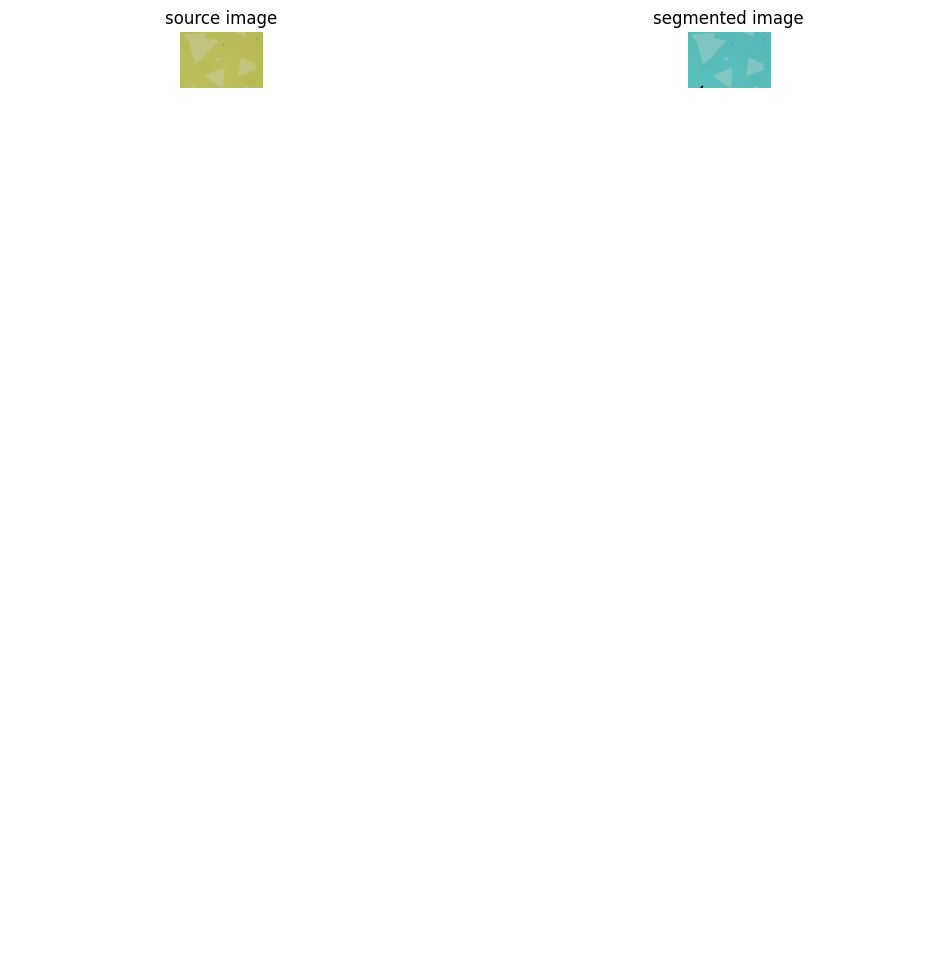

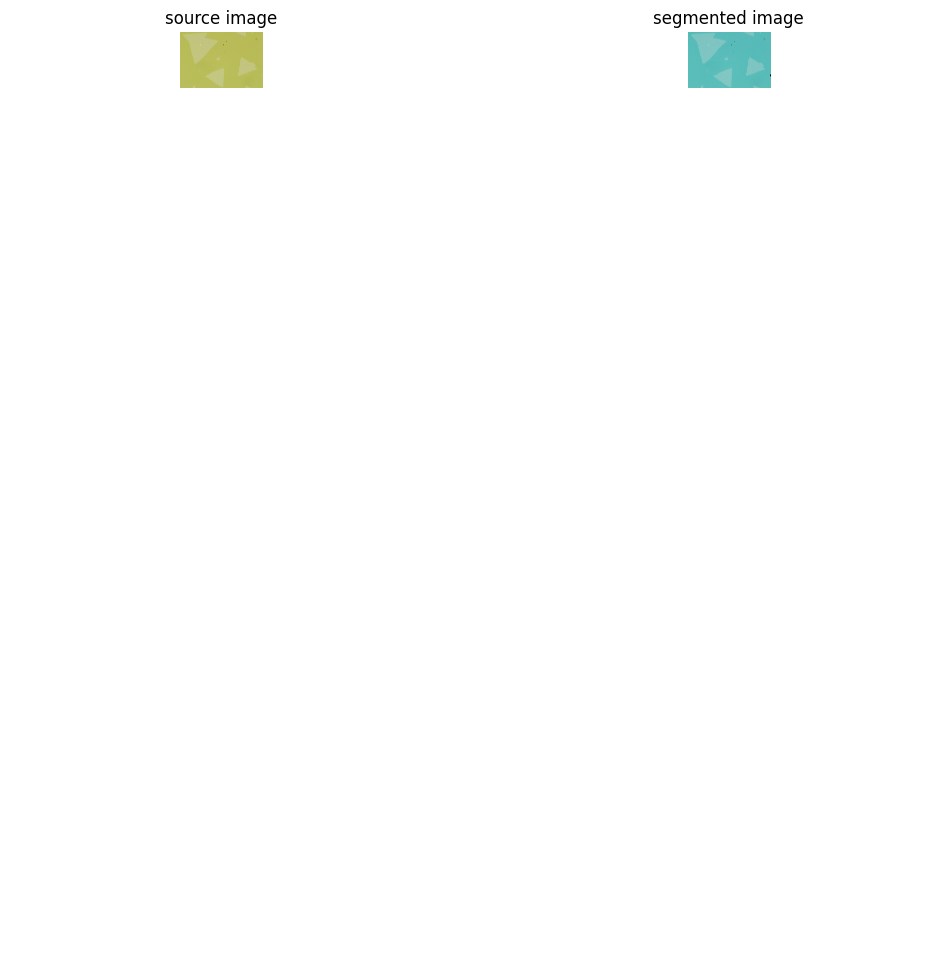

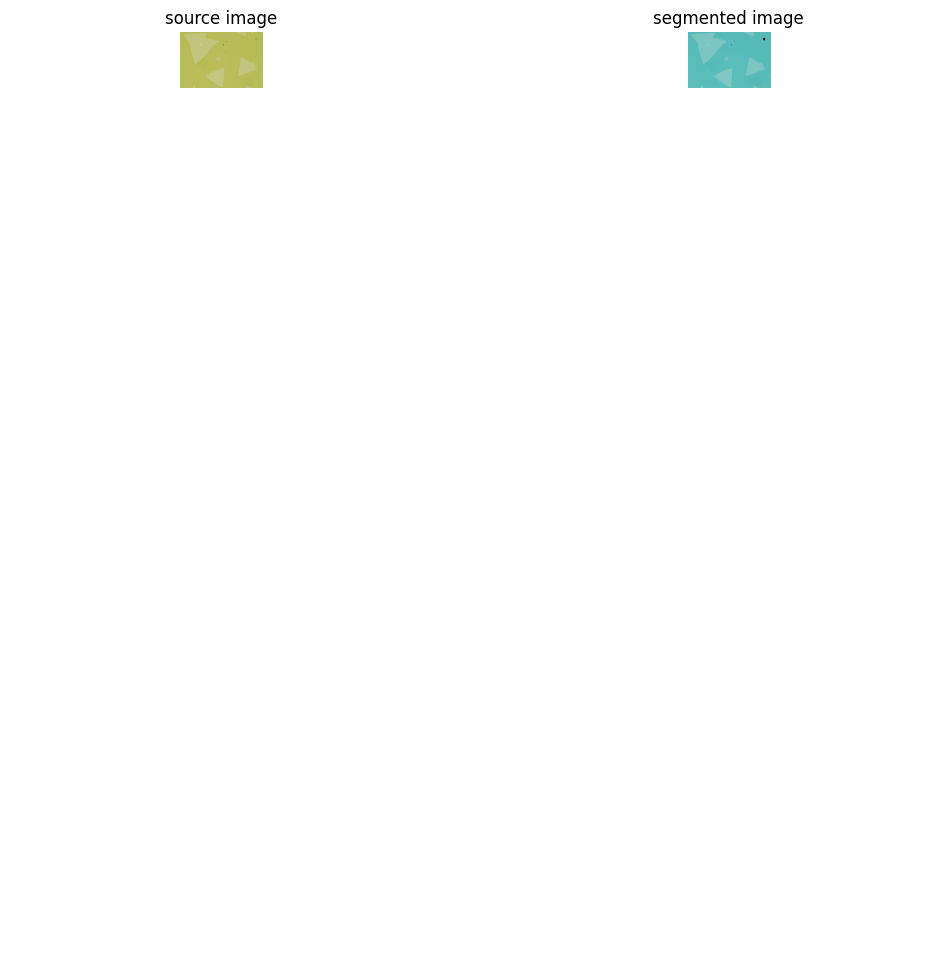

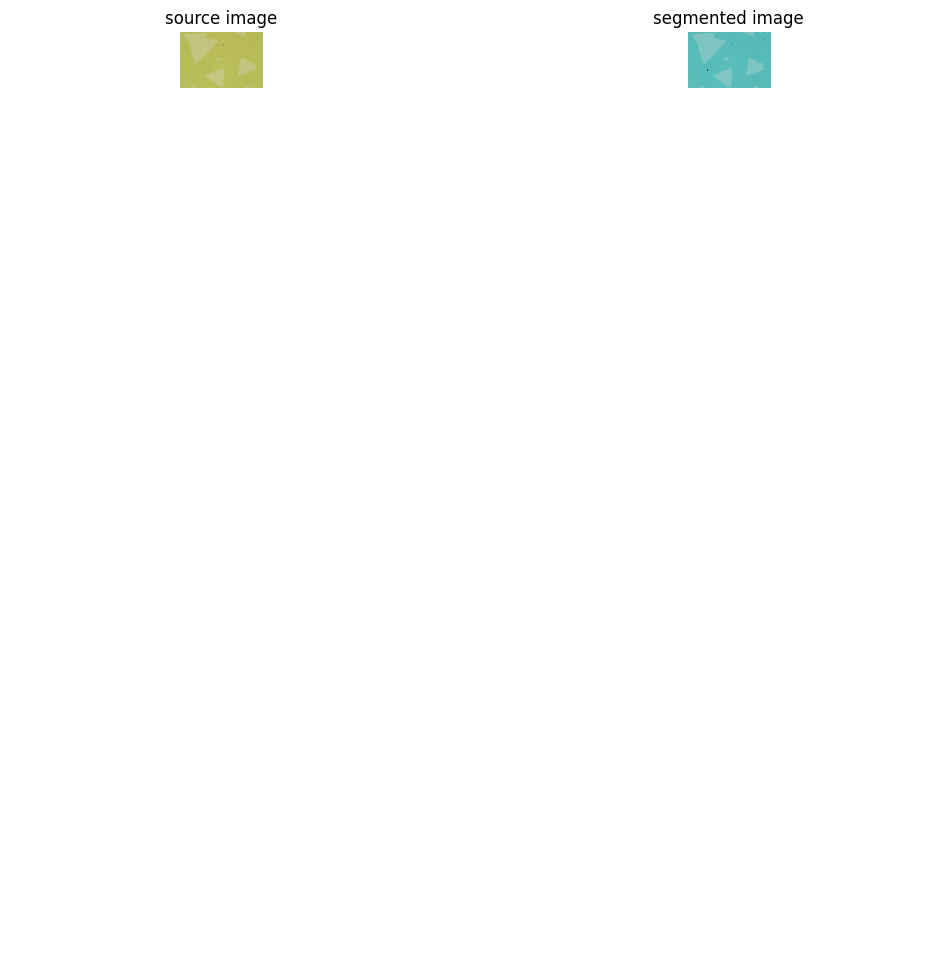

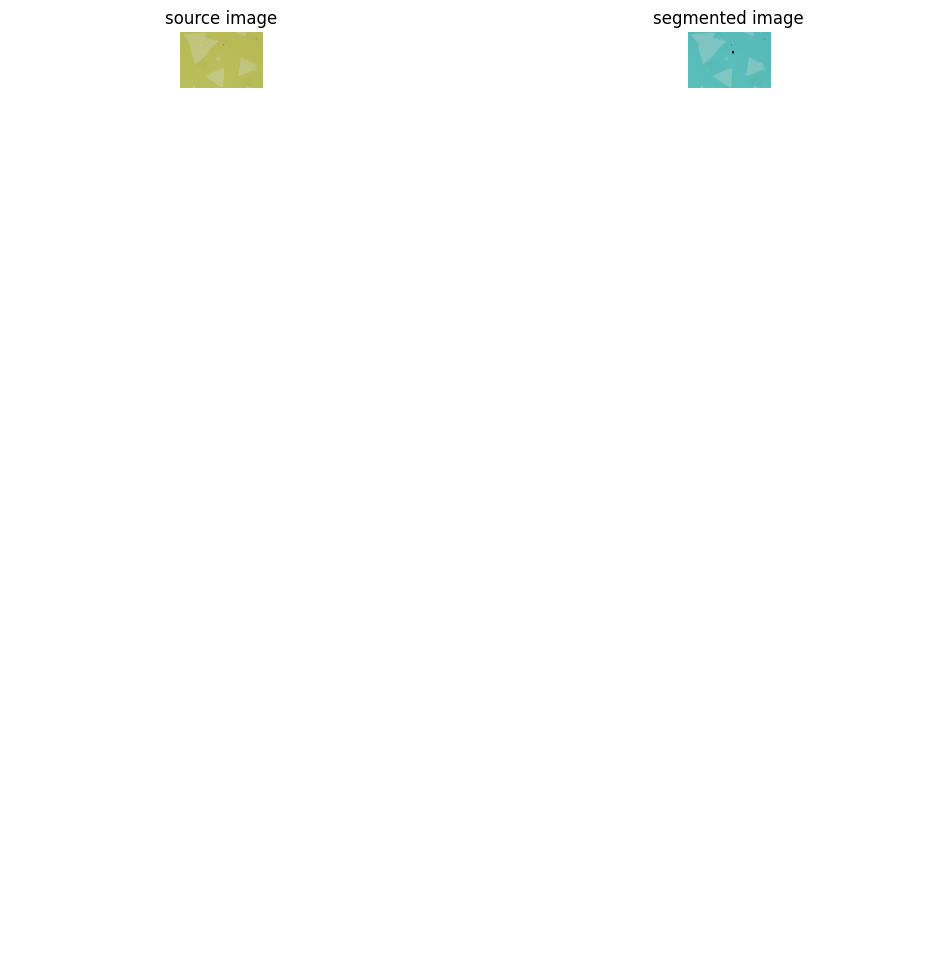

In [ ]:
print(len(sam_result))
maskk = []
for i in range(len(sam_result)):
    maskk.append(sam_result[i]["segmentation"])
    temp = image_rgb.copy()
    temp[maskk[i]] = 0.0

    sv.plot_images_grid(
    images=[image_bgr, temp],
    grid_size=(len(sam_result), 2),
    titles=['source image', 'segmented image']
    )

In [ ]:
import numpy as np


# Get the coordinates of the pixels that are part of the mask
for i in range(len(maskk)):
  mask_coordinates = np.nonzero(maskk[i])

# Print the coordinates
  print(maskk[i])
  print(mask_coordinates)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array([1437, 1437, 1437, ..., 2199, 2199, 2199]), array([1745, 1746, 1747, ..., 1669, 1670, 1671]))
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array([2141, 2141, 2141, ..., 2471, 2471, 2471]), array([2632, 2633, 2634, ..., 2612, 2613, 2614]))
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array

In [ ]:
import numpy as np
Ang=[ ]


def Angle(mc):
  x = mc[1]
  y = mc[0]
  min_y = y.min()

  max_y = y.max()

  idminy = np.where(y == min_y)

  idmaxy = np.where(y == max_y)

#idminx = np.where(x == min_x)
#print(idminx)
  xofminy = x[idminy]


#yofminx = y[idminx]
#print(yofminx)
  xofmaxy = x[idmaxy]

  xofminy= np.median(xofminy)
 # print('The point of minimum y is: ' + f'({xofminy},{min_y})')
  xofmaxy= np.median(xofmaxy)
#  print('The point of maximum y is: ' + f'({xofmaxy}, {max_y})')

  slope= np.abs((min_y-max_y)/(xofminy-xofmaxy))
  angle = np.arctan(slope)

  true_angle= np.rad2deg(angle)
  return true_angle
 # print(f'The angle of the leftmost edge of the triangle is {angle}rad and {true_angle}degrees')


# Get the coordinates of the pixels that are part of the mask
for i in range(len(maskk)):
  mask_coordinates = np.nonzero(maskk[i])

# Print the coordinates
 # print(mask_coordinates)
  Ang.append(Angle(mask_coordinates))
print(Ang)


[42.74892745894424, 84.14780727945906, 80.10251213904694, 72.71755859644203, 41.368326843839625, 62.54981683783969, 49.65335158726839, 89.11176450476023, 76.26118627870774, 75.67106033233836, 77.75087658024421, 87.91201616727665, 79.3150875999973, 84.50767544287257]
